In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
from scipy import interpolate
import pylab as pyl
import scipy.stats as stats

%matplotlib inline

1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to find visually the regions.
* Use `scipy.optimize.minimize()`, optionally trying its optional arguments.

Global minima of xy1: [ 0.08984184 -0.71265627]
The value of the function for that point is: -1.031628453489629


Global minima of xy2: [-0.08984184  0.71265627]
The value of the function for that point is: -1.031628453489629




Initial guess [0,0]


Global minima of x0: [0. 0.]
Number of iteration: 0
The value of the function for that point is: 0.0
We can notice that with the initial gues (0,0), the function remain in that point, nit = 0, since it is a minima, thus underline
that the chooice of the initial point is very important.




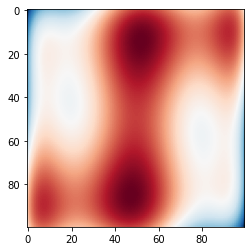

In [2]:
def fun(var):
    x, y = var
    return ((4 - 2.1*(x**2) + ((x**4)/3))* (x**2) + x * y + (4 * (y**2) - 4) * (y**2))


#Find global minima

xy1 = [-2, -1]
xy2 = [2, 1]
glb_min1 = optimize.minimize(fun, xy1)
glb_min2 = optimize.minimize(fun, xy2)


if glb_min1.success:
    fitted_params1 = glb_min1.x
    value1 = glb_min1.fun
    print("Global minima of xy1: " + str(fitted_params1))
    print("The value of the function for that point is: " + str(value1))
    print("\n")
else:
    raise ValueError(glb_min1.message)
    


if glb_min2.success:
    fitted_params2 = glb_min2.x
    value2 = glb_min2.fun
    print("Global minima of xy2: " + str(fitted_params2))
    print("The value of the function for that point is: " + str(value2))
else:
    raise ValueError(glb_min2.message)

    

print("\n")
print("\n")    
print("Initial guess [0,0]")
print("\n")

xy0 = [0, 0]
glb_min0 = optimize.minimize(fun, xy0)



if glb_min0.success:
    fitted_params0 = glb_min0.x
    value0 = glb_min0.fun
    nit = glb_min0.nit
    print("Global minima of x0: " + str(fitted_params0))
    print("Number of iteration: " + str(nit))
    print("The value of the function for that point is: " + str(value0))
else:
    raise ValueError(glb_min0.message)

print("We can notice that with the initial gues (0,0), the function remain in that point, nit = 0, since it is a minima, thus underline")
print("that the chooice of the initial point is very important.")
print("\n") 

x = np.linspace(-2, 2, 100)
y = np.linspace(-1, 1, 100)

XY = np.meshgrid(x, y) # grid of point
Z = fun(XY) # evaluation of the function on the grid

im = pyl.imshow(Z,cmap=pyl.cm.RdBu) # drawing the function

2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  `17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18`

min: `-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58`

* Plot these temperatures.
* Find a suitable a function that can describe min and max temperatures. 
* Fit this function to the data with `scipy.optimize.curve_fit()`.
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

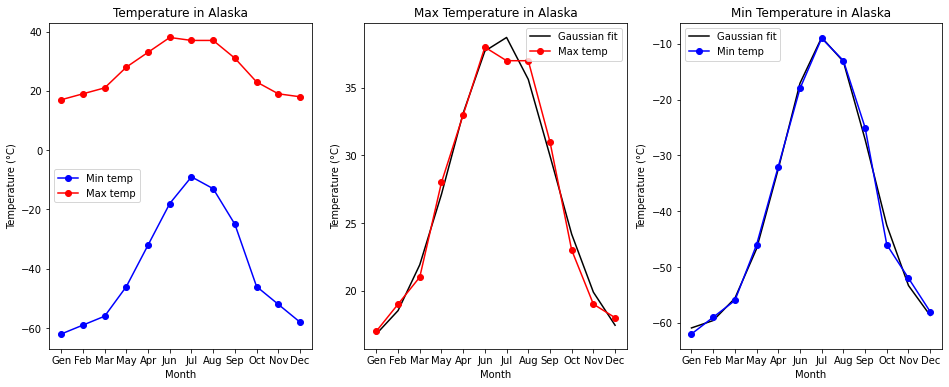

In [3]:
def G(x,a,b,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2)) + b

x_lb = ['Gen','Feb','Mar','May','Apr','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
max_temp = np.array([17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18])
min_temp = np.array([-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58])

fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize = (16,6)) 

ax0.plot(x_lb,min_temp, c="b" , label ="Min temp", marker = 'o')
ax0.plot(x_lb,max_temp, c="r", label ="Max temp", marker = 'o' )
ax0.set_xlabel('Month')
ax0.set_ylabel('Temperature (°C)')
ax0.set_title('Temperature in Alaska')
ax0.legend()


popt_max_temp, pcov_max_temp = optimize.curve_fit(G, np.arange(1,len(max_temp)+1), max_temp, p0 = [1,0,5,1], full_output=False)
popt_min_temp, pcov_min_temp = optimize.curve_fit(G, np.arange(1,len(min_temp)+1), min_temp, p0 = [1,0,5,1], full_output=False)


ax1.plot(x_lb, G(np.arange(1,len(min_temp)+1), popt_max_temp[0], popt_max_temp[1], popt_max_temp[2], popt_max_temp[3]), label='Gaussian fit',c="black")
ax1.plot(x_lb,max_temp, c="r" , label ="Max temp", marker = 'o')
ax1.set_xlabel('Month')
ax1.set_ylabel('Temperature (°C)')
ax1.set_title('Max Temperature in Alaska')
ax1.legend()

ax2.plot(x_lb, G(np.arange(1,len(min_temp)+1), popt_min_temp[0], popt_min_temp[1], popt_min_temp[2], popt_min_temp[3]) , label='Gaussian fit', c = "black")
ax2.plot(x_lb,min_temp, c="b" , label ="Min temp", marker = 'o')
ax2.set_xlabel('Month')
ax2.set_ylabel('Temperature (°C)')
ax2.set_title('Min Temperature in Alaska')
ax2.legend()



In [4]:
off_real = np.array(max_temp) - np.array(min_temp)
off_fit = G(np.arange(1,len(max_temp)+1), popt_max_temp[0], popt_max_temp[1], popt_max_temp[2], popt_max_temp[3]) - G(np.arange(1,len(min_temp)+1), popt_min_temp[0], popt_min_temp[1], popt_min_temp[2], popt_min_temp[3])
offset = np.absolute(off_real - off_fit)

print("The differences from real data and the fitted one are quite low, so we can concluded that the fitting is well approxiated.")
print("\n")
print(offset)


The differences from real data and the fitted one are quite low, so we can concluded that the fitting is well approxiated.


[1.29013234 0.11466592 0.52313031 0.15849435 0.55153345 1.22049326
 1.57270223 1.2067354  1.09194141 2.30840342 2.20466636 0.12561908]


3\. **Fit the residues**

Read the `data/residuals_261.pkl` file. If you haven't it already, download it from here:

```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```

The feature name "residual" contains the residuals (defined as $y_i - \hat{y}_i$) of a linear regression as a function of the independent variable "distances".

- Considering only the "residual" feature, create an histogram with the appropriate binning and display it.
- Set the appropriate Poisson uncertainty for each bin (thus, for each bin, $\sigma_i = \sqrt{n_i}$, where $n_i$ is the number of entries in each bin)
- By looking at the distribution of the residuals, define an appropriate function and fit it to the histogram of the residuals
- Perform a goodness-of-fit test. Is the p-value of the fit satisfactory?

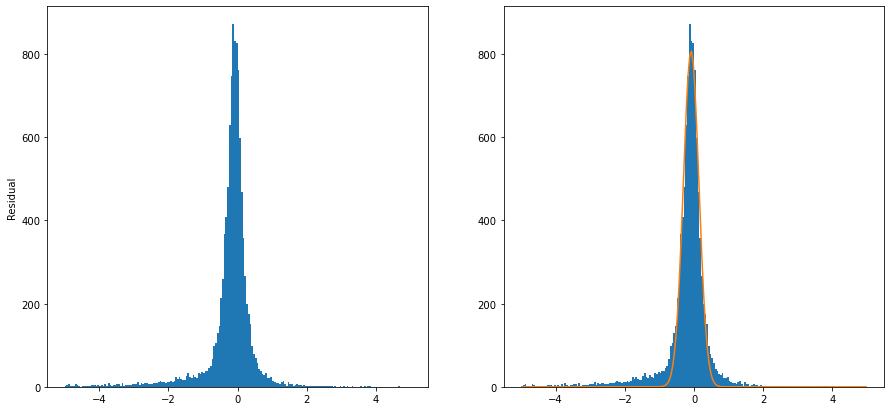

In [5]:
datafile = "data/residuals_261.pkl"
df_res = pd.read_pickle(datafile)
df_res = pd.DataFrame(df_res.flat[0])
df_res = df_res['residuals']

x = np.array(df_res)
nbins = 200

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

bin_counts, bin_edges, _ = ax1.hist(x, nbins,  range = (-5, 5), density=False, cumulative=False)

ax1.set_ylabel("Residual")

bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Generate some dummy error values, of the same dimensions as the bin counts
h_error = np.sqrt(bin_counts)

#The histogram looks like a Gaussian function, so even here I will use it
def G(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

popt, pcov = optimize.curve_fit(G, bin_centers, bin_counts, full_output=False, p0=[ 1, 0, 1])


bin_counts, bin_edges, _ = ax2.hist(df_res, bins=nbins, range = (-5, 5), density=False, cumulative=False)
ax2.plot(bin_centers, G(bin_centers, popt[0], popt[1], popt[2]))



In [6]:
ssr = np.sum((bin_counts - G(bin_centers, popt[0], popt[1], popt[2]))**2)
tss = np.sum((np.mean(bin_counts) - bin_counts)**2)

rsq = 1 - ssr / tss
deg_fre = nbins - 1 #Degree of freedom
h_error [h_error == 0] = 0.00000001 #I need to replace the zero value to avoid division failure

print("The root square error: " + str(rsq))

chi2 = np.sum(((bin_counts - G(bin_centers, popt[0], popt[1], popt[2]))**2) / h_error)
print("chi-square: ", chi2)

pvalue = 1. - stats.chi2.cdf(chi2, deg_fre)
print("The p-value is: ", pvalue)

The root square error: 0.9814833562070284
chi-square:  9977.008445920734
The p-value is:  0.0


4\. **Temperatures in Munich**

Get the following data file:

```bash
https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
```

which gives the temperature in Munich every day for several years.


Fit the following function to the data:

$$f(t) = a \cos(2\pi t + b)+c$$

where $t$ is the time in years.

- Make a plot of the data and the best-fit model in the range 2008 to 2012.

   - What are the best-fit values of the parameters?

   - What is the overall average temperature in Munich, and what are the typical daily average values predicted by the model for the coldest and hottest time of year?

   - What is the meaning of the $b$ parameter, and what physical sense does it have?


- Now fit the data with the function $g(x)$, which has 1 more parameter than $f(x)$.
$$g(x) = a \cos(2\pi b t + c)+d$$
   - What are the RSS for $f(x)$ and $g(x)$?
   - Use the Fisher F-test to determine whether the additional parameter is motivated.

,Date,Temperature
4748,2008.00274,-2.94444
4749,2008.00548,-2.66667
4750,2008.00821,-2.66667
4751,2008.01095,-2.00000
4752,2008.01369,-1.94444
...,...,...
6204,2011.98836,3.44444
6205,2011.99110,1.27778
6206,2011.99384,2.88889
6207,2011.99658,1.83333


Best values are:
a:  -9.962034675524981
b:  12.331742861921638
c:  9.262821311550773


The overall mean temperature is:  9.261252084144246
The hottest days mean temperature is:  15.609009399872932
The coldest mean temperature is:  2.9134947684155614


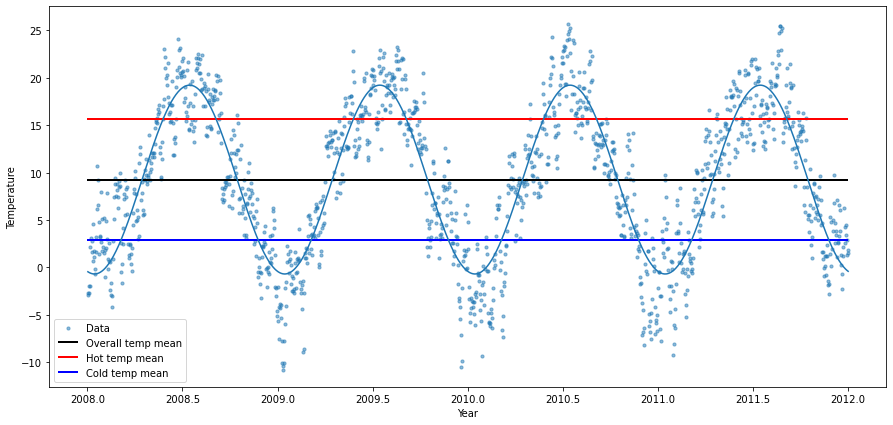

In [12]:
def f(t,a,b,c):
    return a * np.cos(2 * np.pi * t + b) + c

datafile = "data/munich_temperatures_average_with_bad_data.txt"
df_mun = pd.read_table(datafile, delimiter=" ", names=['Date', 'Temperature'])
#There are two values higher than 50, I have decided to neglect them to have a better visuallization.
constrain = (df_mun['Date']>=2008) & (df_mun['Date']<=2012) & (df_mun['Temperature']<50)
df_mun = df_mun[constrain]
display(df_mun)


popt, pcov = optimize.curve_fit(f, df_mun['Date'], df_mun['Temperature'], full_output=False)

a = popt[0]
b = popt[1]
c = popt[2]

print("Best values are:")
print("a: ", a)
print("b: ", b)
print("c: ", c)

print("\n")

fig, ax = plt.subplots(figsize=(15, 7))

ax.scatter(df_mun['Date'],df_mun['Temperature'], label='Data', alpha=0.5, s=10)
ax.set_ylabel("Temperature")
ax.set_xlabel("Year")
ax.plot(df_mun['Date'],f(df_mun['Date'],a,b,c))

mean = np.mean(f(df_mun['Date'],a,b,c))
print("The overall mean temperature is: ", mean)

mean_hot = np.mean(np.abs(f(df_mun['Date'],a,b,c-mean))) + mean
print("The hottest days mean temperature is: ", mean_hot)

mean_cold = np.mean(-np.abs(f(df_mun['Date'],a,b,c-mean))) + mean
print("The coldest mean temperature is: ", mean_cold)

ax.hlines(y = mean, xmin=2008, xmax=2012, linewidth=2, color ='black' , label ="Overall temp mean")
ax.hlines(y = mean_hot, xmin=2008, xmax=2012, linewidth=2, color='r' , label ="Hot temp mean")
ax.hlines(y = mean_cold, xmin=2008, xmax=2012, linewidth=2, color='b' , label ="Cold temp mean")
ax.legend()

As we can notice in the graph below, the b parameter cause a shift in the year axis, phisically it could rapresent the
position of the country with respect of the equator, Munich(b=12) has the higher temperatures in the middle of the year
(May,June,July...) instead with b = 3 we have in the same period of time the winter.
Obviously, if we want to analyse a country in a different position it requires a change even in the other parameters, 
changing b is not enought because the temperatures are differents


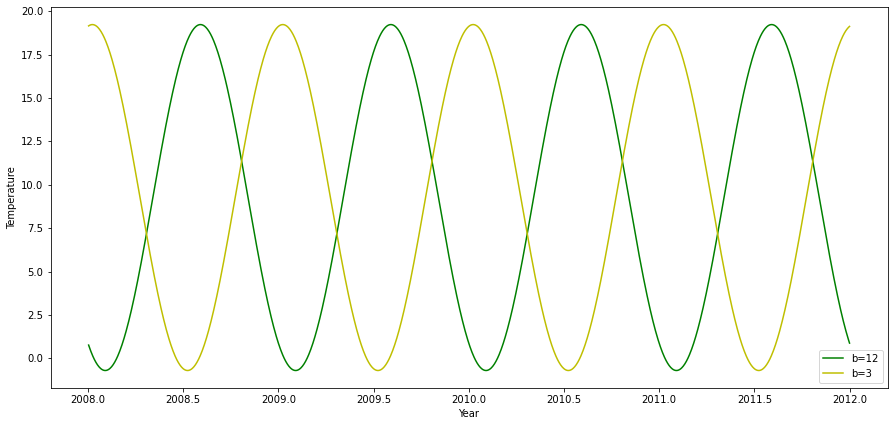

In [13]:
#Let's try to change the value of the b parameter

fig1, ax1 = plt.subplots(figsize=(15, 7))
ax1.set_ylabel("Temperature")
ax1.set_xlabel("Year")
ax1.plot(df_mun['Date'],f(df_mun['Date'],a,12,c), label = "b=12", c="g")
ax1.plot(df_mun['Date'],f(df_mun['Date'],a,3,c), label = "b=3", c="y")
ax1.legend()

print("As we can notice in the graph below, the b parameter cause a shift in the year axis, phisically it could rapresent the")
print("position of the country with respect of the equator, Munich(b=12) has the higher temperatures in the middle of the year")
print("(May,June,July...) instead with b = 3 we have in the same period of time the winter.")
print("Obviously, if we want to analyse a country in a different position it requires a change even in the other parameters, ")
print("changing b is not enought because the temperatures are differents")

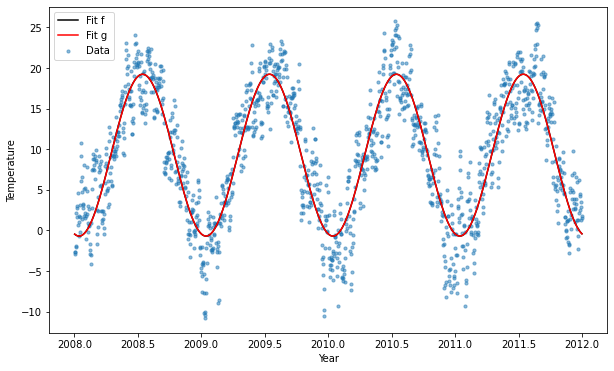

In [14]:
def g(t,a,b,c,d):
    return a * np.cos(2 * np.pi * b * t + c) + d

popt_g, pcov_g = optimize.curve_fit(g, df_mun['Date'], df_mun['Temperature'], full_output=False)

a_g = popt_g[0]
b_g = popt_g[1]
c_g = popt_g[2]
d_g = popt_g[3]

fig2, ax2 = plt.subplots(figsize=(10, 6))
ax2.scatter(df_mun['Date'], df_mun['Temperature'], label='Data', alpha=0.5, s=10)
ax2.plot(df_mun['Date'], f(df_mun['Date'], a, b, c), label='Fit f', c='black')
ax2.plot(df_mun['Date'], g(df_mun['Date'], a_g, b_g, c_g, d_g), label='Fit g', c='red')
ax2.set_ylabel("Temperature")
ax2.set_xlabel("Year")
ax2.legend()

In [15]:
def Ftest(ssr_1, ssr_2, ndof_1, ndof_2, nbins, verbose=False):
    F = ((ssr_1 - ssr_2)/(ndof_2 - ndof_1)) / (ssr_2/(nbins - ndof_2))
    CL = 1. - stats.f.cdf(F, ndof_2 - ndof_1, nbins - ndof_2)
    if verbose: print("CL: %.3f" % CL, ", additional parameter necessary:", "YES" if CL < 0.10 else "NO")
    return CL

ssr_f = np.sum((df_mun['Temperature'] - f(df_mun['Date'], a, b, c))**2)
ssr_g = np.sum((df_mun['Temperature'] - g(df_mun['Date'], a_g, b_g, c_g, d_g))**2)

print("SSR f : ", ssr_f)
print("SSR g : ", ssr_g)

print("\nTest f vs g:")
cl_3_vs_4 = Ftest(ssr_f, ssr_g, 3, 4, len(df_mun['Temperature']), verbose=True)

SSR f :  18669.515394576345
SSR g :  18669.225430539904

Test f vs g:
CL: 0.881 , additional parameter necessary: NO
